# Recurrent Neural Networks

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


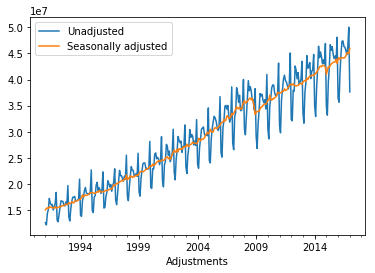

In [5]:
df.plot()

In [6]:
split_date = pd.Timestamp('01-01-2011')

In [7]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

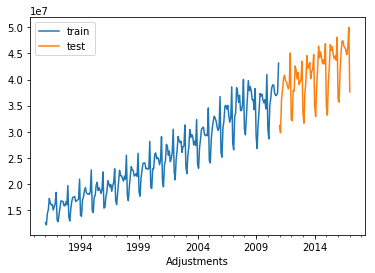

In [8]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [10]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [15]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 0s 1ms/step - loss: 0.1402
Epoch 2/200
239/239 [==============================] - 0s 447us/step - loss: 0.0351
Epoch 3/200
239/239 [==============================] - 0s 455us/step - loss: 0.0219
Epoch 4/200
239/239 [==============================] - 0s 456us/step - loss: 0.0195
Epoch 5/200
239/239 [==============================] - 0s 410us/step - loss: 0.0176
Epoch 6/200
239/239 [==============================] - 0s 387us/step - loss: 0.0159
Epoch 7/200
239/239 [==============================] - 0s 396us/step - loss: 0.0145
Epoch 8/200
239/239 [==============================] - 0s 521us/step - loss: 0.0133
Epoch 9/200
239/239 [==============================] - 0s 424us/step - loss: 0.0124
Epoch 10/200
239/239 [==============================] - 0s 371us/step - loss: 0.0116
Epoch 11/200
239/239 [==============================] - 0s 432us/step - loss: 0.0111
Epoch 12/200
239/239 [==============================] - 0s 442us/step - loss

In [16]:
y_pred = model.predict(X_test)

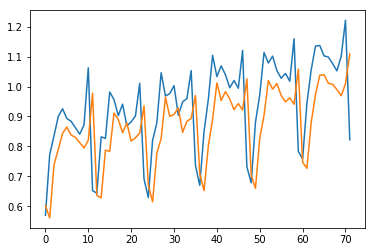

In [17]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [18]:
from keras.layers import LSTM

In [19]:
X_train.shape

(239, 1)

In [20]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [21]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [22]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0836
Epoch 2/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0276
Epoch 3/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 4/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 5/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0134
Epoch 6/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 7/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0104
Epoch 8/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0100
Epoch 9/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0099
Epoch 10/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0100
Epoch 00010: early stopping


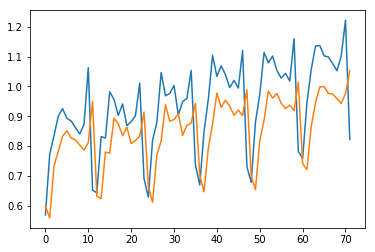

In [24]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [25]:
train_sc.shape

(240, 1)

In [26]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [27]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [28]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [29]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [30]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [31]:
X_train.shape

(228, 12)

In [32]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [33]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 2/200
228/228 [==============================] - 0s 850us/step - loss: 0.0079
Epoch 3/200
228/228 [==============================] - 0s 858us/step - loss: 0.0056
Epoch 4/200
228/228 [==============================] - 0s 854us/step - loss: 0.0041
Epoch 5/200
228/228 [==============================] - 0s 821us/step - loss: 0.0034
Epoch 6/200
228/228 [==============================] - 0s 806us/step - loss: 0.0025
Epoch 7/200
228/228 [==============================] - 0s 841us/step - loss: 0.0020
Epoch 8/200
228/228 [==============================] - 0s 849us/step - loss: 0.0019
Epoch 9/200
228/228 [==============================] - 0s 858us/step - loss: 0.0016
Epoch 10/200
228/228 [==============================] - 0s 817us/step - loss: 0.0013
Epoch 11/200
228/228 [==============================] - 0s 769us/step - loss: 0.0015
Epoch 00011: early stopping


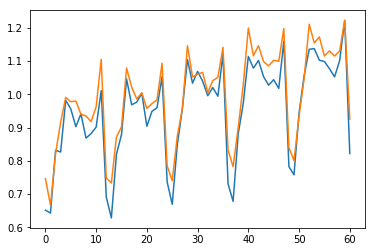

In [35]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [36]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [37]:
X_train_t.shape

(228, 1, 12)

In [38]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0297
Epoch 2/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0101
Epoch 3/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 4/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 5/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 6/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 7/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 8/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 9/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0039
Epoch 10/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0035
Epoch 11/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 12/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 13/100


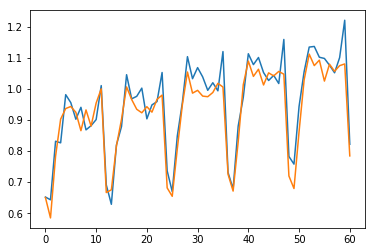

In [41]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [42]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [43]:
X_train_t.shape

(228, 12, 1)

In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [47]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [49]:
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1)

In [50]:
model.fit(X_train_t, y_train, epochs = 100,
         batch_size = 1, verbose = 1,
         callbacks = [early_stop])

Epoch 1/100
228/228 [==============================] - 4s 16ms/step - loss: 0.0606
Epoch 2/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0127
Epoch 3/100
228/228 [==============================] - 3s 13ms/step - loss: 0.0096
Epoch 4/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0087
Epoch 5/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0084
Epoch 6/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0083
Epoch 7/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0083
Epoch 00007: early stopping


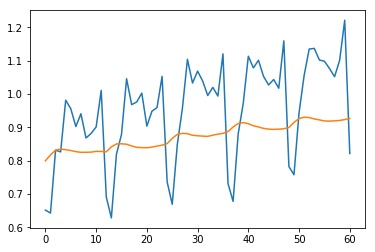

In [51]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [54]:
model.fit(X_train_t, y_train, epochs = 600,
         batch_size = 32, verbose = 1)

Epoch 1/600
228/228 [==============================] - 0s 462us/step - loss: 0.0076
Epoch 2/600
228/228 [==============================] - 0s 422us/step - loss: 0.0075
Epoch 3/600
228/228 [==============================] - 0s 508us/step - loss: 0.0075
Epoch 4/600
228/228 [==============================] - 0s 434us/step - loss: 0.0075
Epoch 5/600
228/228 [==============================] - 0s 472us/step - loss: 0.0075
Epoch 6/600
228/228 [==============================] - 0s 461us/step - loss: 0.0075
Epoch 7/600
228/228 [==============================] - 0s 465us/step - loss: 0.0075
Epoch 8/600
228/228 [==============================] - 0s 478us/step - loss: 0.0075
Epoch 9/600
228/228 [==============================] - 0s 468us/step - loss: 0.0075
Epoch 10/600
228/228 [==============================] - 0s 473us/step - loss: 0.0075
Epoch 11/600
228/228 [==============================] - 0s 468us/step - loss: 0.0074
Epoch 12/600
228/228 [==============================] - 0s 475us/step - lo

228/228 [==============================] - 0s 442us/step - loss: 0.0068
Epoch 98/600
228/228 [==============================] - 0s 452us/step - loss: 0.0068
Epoch 99/600
228/228 [==============================] - 0s 455us/step - loss: 0.0068
Epoch 100/600
228/228 [==============================] - 0s 435us/step - loss: 0.0068
Epoch 101/600
228/228 [==============================] - 0s 400us/step - loss: 0.0068
Epoch 102/600
228/228 [==============================] - 0s 398us/step - loss: 0.0068
Epoch 103/600
228/228 [==============================] - 0s 392us/step - loss: 0.0068
Epoch 104/600
228/228 [==============================] - 0s 398us/step - loss: 0.0068
Epoch 105/600
228/228 [==============================] - 0s 429us/step - loss: 0.0068
Epoch 106/600
228/228 [==============================] - 0s 454us/step - loss: 0.0068
Epoch 107/600
228/228 [==============================] - 0s 446us/step - loss: 0.0068
Epoch 108/600
228/228 [==============================] - 0s 462us/step

228/228 [==============================] - 0s 473us/step - loss: 0.0061
Epoch 193/600
228/228 [==============================] - 0s 470us/step - loss: 0.0060
Epoch 194/600
228/228 [==============================] - 0s 421us/step - loss: 0.0061
Epoch 195/600
228/228 [==============================] - 0s 397us/step - loss: 0.0060
Epoch 196/600
228/228 [==============================] - 0s 429us/step - loss: 0.0060
Epoch 197/600
228/228 [==============================] - 0s 453us/step - loss: 0.0060
Epoch 198/600
228/228 [==============================] - 0s 423us/step - loss: 0.0060
Epoch 199/600
228/228 [==============================] - 0s 454us/step - loss: 0.0060
Epoch 200/600
228/228 [==============================] - 0s 437us/step - loss: 0.0060
Epoch 201/600
228/228 [==============================] - 0s 456us/step - loss: 0.0059
Epoch 202/600
228/228 [==============================] - 0s 448us/step - loss: 0.0060
Epoch 203/600
228/228 [==============================] - 0s 426us/st

228/228 [==============================] - 0s 521us/step - loss: 0.0040
Epoch 288/600
228/228 [==============================] - 0s 496us/step - loss: 0.0039
Epoch 289/600
228/228 [==============================] - 0s 468us/step - loss: 0.0040
Epoch 290/600
228/228 [==============================] - 0s 448us/step - loss: 0.0039
Epoch 291/600
228/228 [==============================] - 0s 447us/step - loss: 0.0039
Epoch 292/600
228/228 [==============================] - 0s 473us/step - loss: 0.0039
Epoch 293/600
228/228 [==============================] - 0s 468us/step - loss: 0.0038
Epoch 294/600
228/228 [==============================] - 0s 475us/step - loss: 0.0038
Epoch 295/600
228/228 [==============================] - 0s 481us/step - loss: 0.0037
Epoch 296/600
228/228 [==============================] - 0s 539us/step - loss: 0.0037
Epoch 297/600
228/228 [==============================] - 0s 544us/step - loss: 0.0037
Epoch 298/600
228/228 [==============================] - 0s 450us/st

228/228 [==============================] - 0s 493us/step - loss: 0.0016
Epoch 383/600
228/228 [==============================] - 0s 491us/step - loss: 0.0016
Epoch 384/600
228/228 [==============================] - 0s 464us/step - loss: 0.0016
Epoch 385/600
228/228 [==============================] - 0s 471us/step - loss: 0.0015
Epoch 386/600
228/228 [==============================] - 0s 460us/step - loss: 0.0015
Epoch 387/600
228/228 [==============================] - 0s 506us/step - loss: 0.0015
Epoch 388/600
228/228 [==============================] - 0s 501us/step - loss: 0.0015
Epoch 389/600
228/228 [==============================] - 0s 493us/step - loss: 0.0015
Epoch 390/600
228/228 [==============================] - 0s 503us/step - loss: 0.0015
Epoch 391/600
228/228 [==============================] - 0s 482us/step - loss: 0.0014
Epoch 392/600
228/228 [==============================] - 0s 492us/step - loss: 0.0014
Epoch 393/600
228/228 [==============================] - 0s 502us/st

228/228 [==============================] - 0s 442us/step - loss: 9.7179e-04
Epoch 477/600
228/228 [==============================] - 0s 451us/step - loss: 9.5115e-04
Epoch 478/600
228/228 [==============================] - 0s 450us/step - loss: 9.7844e-04
Epoch 479/600
228/228 [==============================] - 0s 469us/step - loss: 9.7481e-04
Epoch 480/600
228/228 [==============================] - 0s 477us/step - loss: 9.5379e-04
Epoch 481/600
228/228 [==============================] - 0s 471us/step - loss: 9.5485e-04
Epoch 482/600
228/228 [==============================] - 0s 488us/step - loss: 9.6787e-04
Epoch 483/600
228/228 [==============================] - 0s 477us/step - loss: 9.3459e-04
Epoch 484/600
228/228 [==============================] - 0s 444us/step - loss: 9.5185e-04
Epoch 485/600
228/228 [==============================] - 0s 466us/step - loss: 9.4100e-04
Epoch 486/600
228/228 [==============================] - 0s 482us/step - loss: 9.3815e-04
Epoch 487/600
228/228 [=

228/228 [==============================] - 0s 471us/step - loss: 9.0676e-04
Epoch 568/600
228/228 [==============================] - 0s 438us/step - loss: 8.7570e-04
Epoch 569/600
228/228 [==============================] - 0s 466us/step - loss: 8.9795e-04
Epoch 570/600
228/228 [==============================] - 0s 526us/step - loss: 8.8322e-04
Epoch 571/600
228/228 [==============================] - 0s 507us/step - loss: 8.7696e-04
Epoch 572/600
228/228 [==============================] - 0s 528us/step - loss: 9.0543e-04
Epoch 573/600
228/228 [==============================] - 0s 747us/step - loss: 8.9263e-04
Epoch 574/600
228/228 [==============================] - 0s 634us/step - loss: 9.0095e-04
Epoch 575/600
228/228 [==============================] - 0s 532us/step - loss: 9.1053e-04
Epoch 576/600
228/228 [==============================] - 0s 548us/step - loss: 8.7441e-04
Epoch 577/600
228/228 [==============================] - 0s 541us/step - loss: 8.8199e-04
Epoch 578/600
228/228 [=

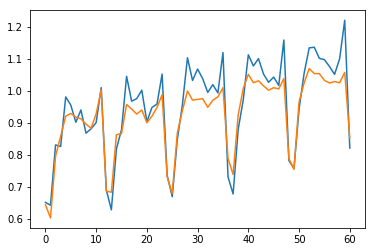

In [55]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)